In [43]:
import numpy as np
import pandas as pd

In [44]:
def generate_next(result, lags, coefficients, noise):
    ans = 0.0
    for i in range(len(lags)):
        ans += result[-lags[i]] * coefficients[i]
    ans = ans + noise * np.random.uniform(low = -1.0, high = 1.0)
    return ans

def generate_sequence(lags, coefficients, initial, length, noise):    
    result = []
    for value in initial:
        result.append(value)
    for _ in range(length - len(initial)):
        result.append(generate_next(result, lags, coefficients, noise))
    return result

In [45]:
np.random.seed(0)
LAT_DIM = 2
LENGTH =100
REAL_DIM = 5
NOISE_COEFFICIENT_LAT = 1e-2
NOISE_COEFFICIENT_Y = 3e-2

lags = [1, 2, 3]
coefficients = [-1.0 + 2.0 * np.cos(np.sqrt(2)), -1.0 + 2 * np.cos(np.sqrt(2)), -1.0]
                

lat_sequences = []
for i in range(LAT_DIM):
    initial = np.random.uniform(low = -1.0, high = 1.0, size = len(lags))
    sequence = generate_sequence(lags, coefficients, initial, LENGTH, NOISE_COEFFICIENT_LAT)
    lat_sequences.append(sequence)

lat_sequences = np.asarray(lat_sequences) 



F = np.random.uniform(low = -1.0, high = 1.0, size = [LAT_DIM, REAL_DIM])
Y = lat_sequences.T.dot(F).T

Y = Y + NOISE_COEFFICIENT_Y * np.random.rand(*Y.shape)
dic = {}
for i in range(REAL_DIM):
    dic[i] = Y[i, :]
dic['timestamps'] = np.arange(Y.shape[1])

dataset = pd.DataFrame(dic)
columns_except_timestamps = [column for column in dataset.columns if column != 'timestamps']
dataset = dataset[['timestamps'] + columns_except_timestamps]
print(dataset.shape)
dataset.head()

(100, 6)


,timestamps,0,1,2,3,4
0,0,-0.314838,0.189050,-0.056335,-0.033402,0.203026
1,1,0.242625,0.008377,-0.049765,-0.298981,-0.763937
2,2,-0.464591,0.251862,-0.091769,-0.075084,0.206911
3,3,0.515012,-0.333974,0.170934,0.336928,0.231450
4,4,-0.246147,0.073784,0.022234,0.177866,0.495577


In [46]:
import math
import os
def launch(dir_for_tmp_files, dataset, id, num_to_test = 50, steps = 100, verbose = False, eval = False,\
          eta = 1, lambdaX = 1, lambdaW = 1, lambdaF = 1, standardize = True, lat_dim = 2,\
           lags = [1, 5, 10, 20, 25, 100]):
    
    name = dir_for_tmp_files + '/' + 'current_launch' + str(id) + '.csv'
    dataset.to_csv(name, sep = ';', index = False)
    if 'timestamps' in dataset.columns:
        timestamps = dataset['timestamps'].as_matrix()
    else:
        timestamps = dataset['timestamp'].as_matrix()
    
    #train_start = math.ceil(timestamps[1])
    #train_end = math.floor(timestamps[timestamps.shape[0] -num_to_test - 1])
    #test_start = math.ceil(timestamps[timestamps.shape[0] -num_to_test])
    #test_end = math.floor(timestamps[-2])
    
    #train_start = 1513357140
    train_start = math.ceil(timestamps[0])
    #train_end = 1517653140
    train_end =  math.floor(timestamps[-num_to_test])
    #test_start = 1517653260
    test_start = math.ceil(timestamps[-num_to_test])
    test_end = math.floor(timestamps[-1])
    command = "./main --dataset_path " + name + " --separator ';'"
    command += ' --train_start ' + str(train_start)
    command += ' --train_end ' + str(train_end)
    command += ' --test_start ' + str(test_start)
    command += ' --test_end ' + str(test_end)
    command += ' --steps ' + str(steps)
    
    if verbose:
        command += ' --verbose 1'
    else:
        command += ' --verbose 0'
    
    if eval:
        command += ' --eval 1'
    else:
        command += ' --eval 0'
    
    command += ' --predictions_out ' + dir_for_tmp_files + '/predictions_' + str(id) + '.csv'
    command += ' --eta ' + str(eta)
    command += ' --lambdaX ' + str(lambdaX)
    command += ' --lambdaW ' + str(lambdaW)
    command += ' --lambdaF ' + str(lambdaF)
    
    if standardize:
        command += ' --standardize 1'
    else:
        command += ' --standardize 0'
    
    command += ' --lags '
    for lag in lags:
        command += str(lag) + ' '
    
    command += ' --lat_dim ' + str(lat_dim)
    command += ' --factor_out ' + dir_for_tmp_files + '/factor_out_' + str(id)
    logs_file_name = 'logs_file_' + str(id)
    command += ' --logs_file ' + dir_for_tmp_files + '/' + logs_file_name
    #print(command)
    os.system(command)
    
    with open(dir_for_tmp_files + '/' + logs_file_name, 'r') as f:
        logs = [line for line in f]   
    
    return logs

In [47]:
NUM_TO_TEST = 20
logs = launch('tmp', dataset, 1, num_to_test = NUM_TO_TEST, steps = 100, verbose = True, eval = True,\
          eta = 0.01, lambdaX = 1, lambdaW = 1e-8, lambdaF = 1e-8, standardize = False, lat_dim = 2,\
           lags = [1, 2, 3])

In [48]:
print("real coefficients: ")
print(np.asarray(coefficients))
W_restored = pd.read_csv('tmp/factor_out_1_W.csv', header = None)
print("restored coefficients: ")
print(W_restored.as_matrix().T)

real coefficients: 
[-0.68811261 -0.68811261 -1.        ]
restored coefficients: 
[[-0.68531343 -0.68432871 -0.99492673]
 [-0.68059885 -0.67759507 -0.99292817]]


In [49]:
predictions = pd.read_csv('tmp/predictions_1.csv')
from matplotlib import pyplot as plt
renaming = {}

for column in predictions.columns:
    if column != 'timestamps':
        renaming[column] = column + '_predicted'
predictions = predictions.rename(columns = renaming)

combined = dataset.join(predictions.set_index('timestamps'), on = 'timestamps')
combined.head()

,timestamps,0,1,2,3,4,0_predicted,1_predicted,2_predicted,3_predicted,4_predicted
0,0,-0.314838,0.189050,-0.056335,-0.033402,0.203026,NaN,NaN,NaN,NaN,NaN
1,1,0.242625,0.008377,-0.049765,-0.298981,-0.763937,NaN,NaN,NaN,NaN,NaN
2,2,-0.464591,0.251862,-0.091769,-0.075084,0.206911,NaN,NaN,NaN,NaN,NaN
3,3,0.515012,-0.333974,0.170934,0.336928,0.231450,NaN,NaN,NaN,NaN,NaN
4,4,-0.246147,0.073784,0.022234,0.177866,0.495577,NaN,NaN,NaN,NaN,NaN


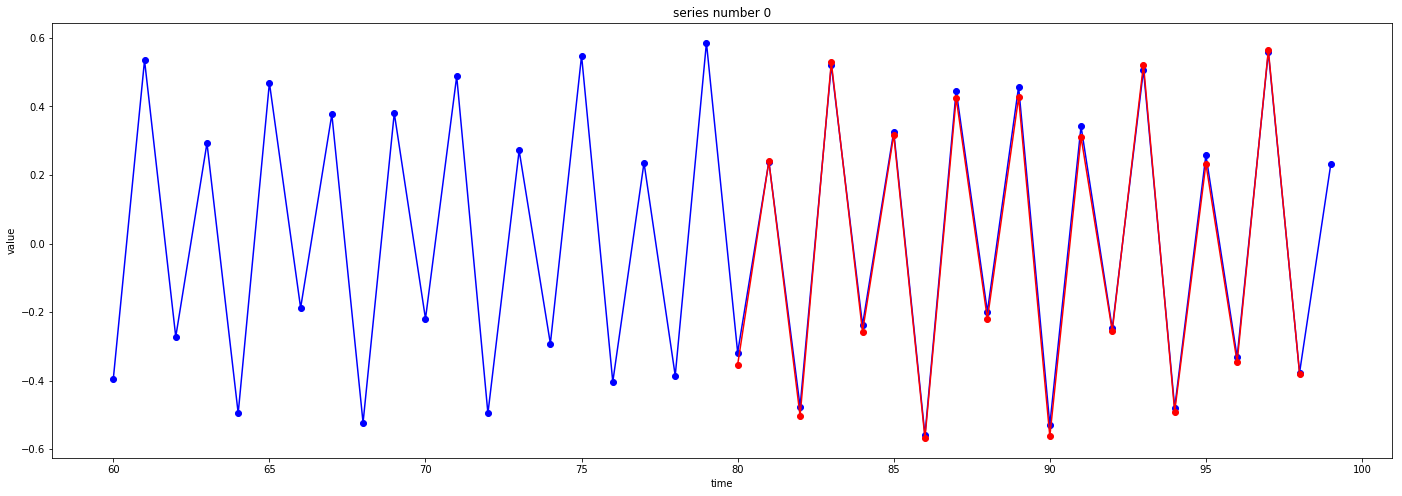

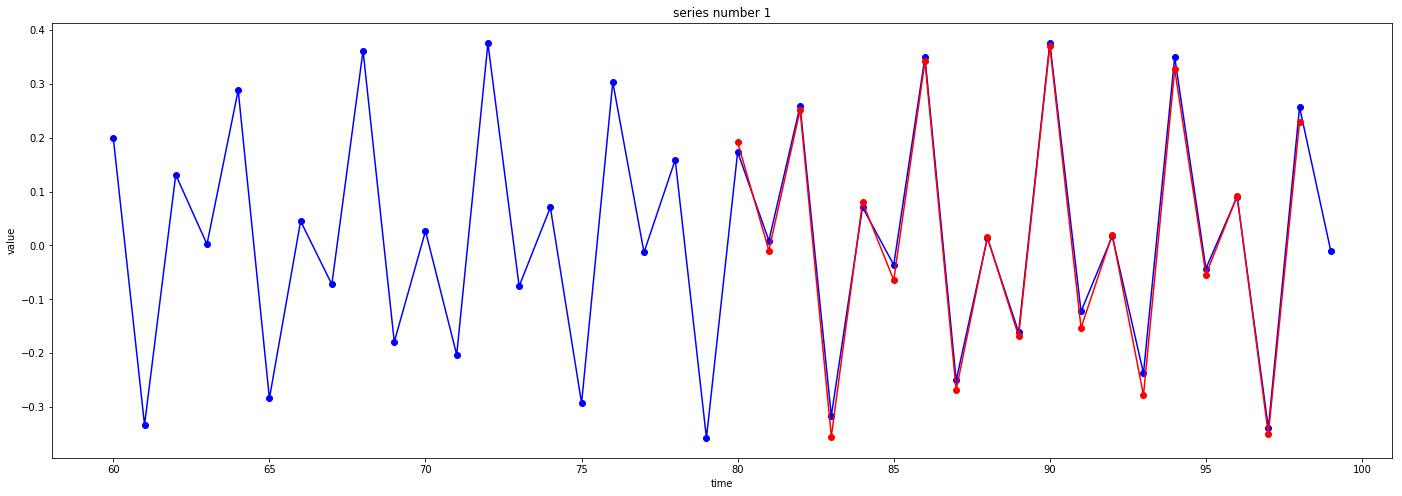

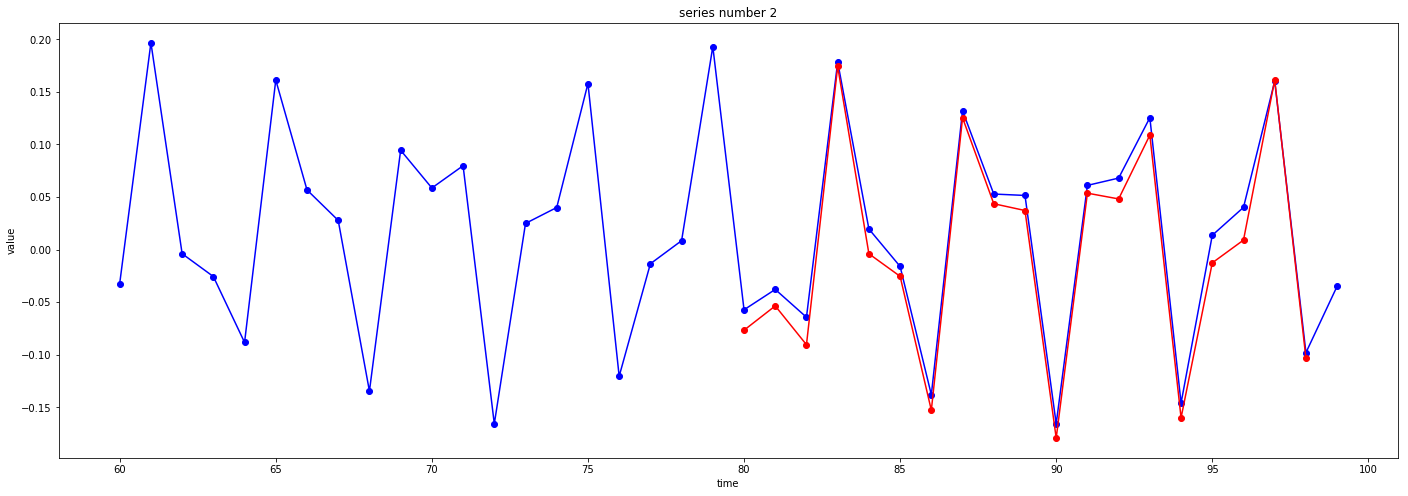

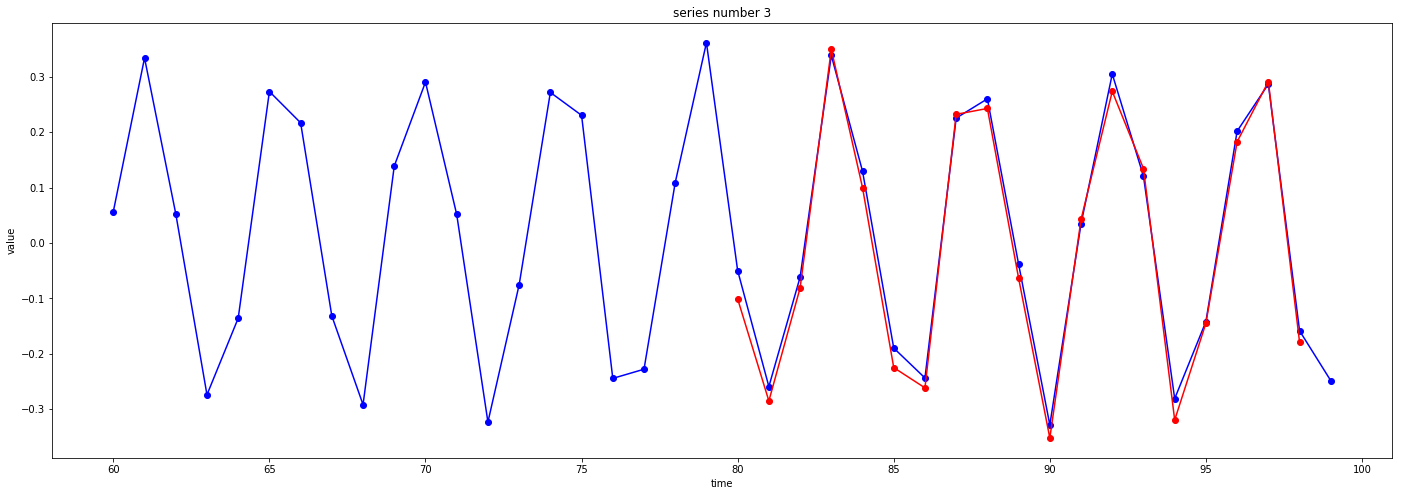

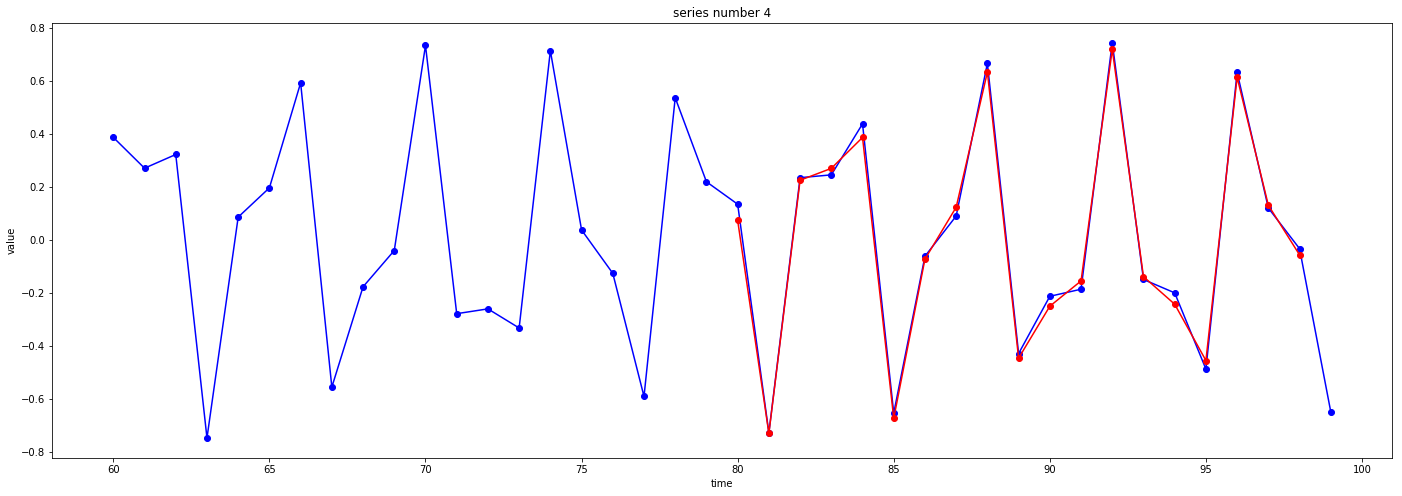

In [50]:
for series in [0, 1, 2, 3, 4]:
    grid = combined['timestamps']
    reals = combined[series]
    predicted = combined[str(series) + '_predicted']
    plt.figure(figsize = (24, 8))
    plt.plot(grid[-2 * NUM_TO_TEST:], reals[-2 * NUM_TO_TEST:], 'bo')
    plt.plot(grid[-2 * NUM_TO_TEST:], reals[-2 * NUM_TO_TEST:], 'b')
    plt.plot(grid[-2 * NUM_TO_TEST:], predicted[-2 * NUM_TO_TEST:], 'ro')
    plt.plot(grid[-2 * NUM_TO_TEST:], predicted[-2 * NUM_TO_TEST:], 'r')
    plt.title("series number " + str(series))
    plt.xlabel('time')
    plt.ylabel('value')
    plt.show()